<a href="https://colab.research.google.com/github/yashyennam/Stock-Price-Prediction-LSTM/blob/master/trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# FOR REPRODUCIBILITY
np.random.seed(7)
from google.colab import files
uploaded = files.upload()
# IMPORTING DATASET 
# dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])

import io
dataset = pd.read_csv(io.BytesIO(uploaded['apple_share_price.csv']), usecols= [1, 2, 3, 4])
dataset = dataset.reindex(index = dataset.index[::-1])

Saving apple_share_price.csv to apple_share_price.csv


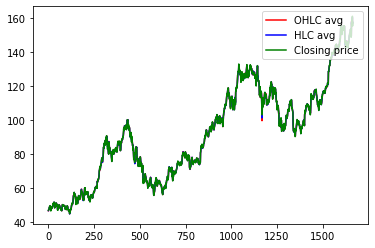

In [3]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [8]:
help(model)

Help on Sequential in module keras.engine.sequential object:

class Sequential(keras.engine.training.Model)
 |  Linear stack of layers.
 |  
 |  # Arguments
 |      layers: list of layers to add to the model.
 |      name: Name given to the model
 |  
 |  # Example
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dense(32))
 |  model.add(Dense(32))
 | 

In [0]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET

def new_dataset(dataset, step_size):
  data_X, data_Y = [], []
  for i in range(len(dataset)-step_size-1):
    a = dataset[i:(i+step_size), 0]
    data_X.append(a)
    data_Y.append(dataset[i + step_size, 0])
  return np.array(data_X), np.array(data_Y)

# THIS FUNCTION CAN BE USED TO CREATE A TIME SERIES DATASET FROM ANY 1D ARRAY	


# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [34]:
# LSTM MODEL Orignal
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# # LSTM MODEL
# model = Sequential()
# model.add(LSTM(64, return_sequences = True))
# model.add(LSTM(32))
# model.add(LSTM(32))
# model.add(LSTM(16))
# model.add(Dense(1))
# model.add(Activation('linear'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 32)             4352      
_________________________________________________________________
lstm_21 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
# # MODEL COMPILING AND TRAINING
# model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
# model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!

In [36]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





 - 5s - loss: 0.0062
Epoch 2/5
 - 4s - loss: 3.4269e-04
Epoch 3/5
 - 4s - loss: 3.0338e-04
Epoch 4/5
 - 4s - loss: 2.7157e-04
Epoch 5/5
 - 4s - loss: 2.4636e-04


In [0]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [39]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.74


In [41]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))


Test RMSE: 2.86


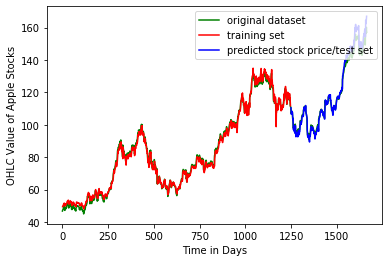

Last Day Value: 166.97572326660156
Next Day Value: 176.8380889892578


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [40]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)